# IMPORT LIBRARY

In [530]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# DATA OVERVIEW

In [531]:
df = pd.read_csv('Clicked Ads Dataset.csv', index_col=0)
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
0,68.95,35,432837300.0,256.09,Perempuan,3/27/2016 0:53,No,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Furniture
1,80.23,31,479092950.0,193.77,Laki-Laki,4/4/2016 1:39,No,Denpasar,Bali,Food
2,69.47,26,418501580.0,236.50,Perempuan,3/13/2016 20:35,No,Surabaya,Jawa Timur,Electronic
3,74.15,29,383643260.0,245.89,Laki-Laki,1/10/2016 2:31,No,Batam,Kepulauan Riau,House
4,68.37,35,517229930.0,225.58,Perempuan,6/3/2016 3:36,No,Medan,Sumatra Utara,Finance


In [532]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Daily Time Spent on Site,987.0,6.492952e+01,1.584470e+01,32.60,5.127000e+01,6.811000e+01,7.846000e+01,9.143000e+01
Age,1000.0,3.600900e+01,8.785562e+00,19.00,2.900000e+01,3.500000e+01,4.200000e+01,6.100000e+01
Area Income,987.0,3.848647e+08,9.407999e+07,97975500.00,3.286330e+08,3.990683e+08,4.583554e+08,5.563936e+08
Daily Internet Usage,989.0,1.798636e+02,4.387014e+01,104.78,1.387100e+02,1.826500e+02,2.187900e+02,2.670100e+02


In [533]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  987 non-null    float64
 1   Age                       1000 non-null   int64  
 2   Area Income               987 non-null    float64
 3   Daily Internet Usage      989 non-null    float64
 4   Male                      997 non-null    object 
 5   Timestamp                 1000 non-null   object 
 6   Clicked on Ad             1000 non-null   object 
 7   city                      1000 non-null   object 
 8   province                  1000 non-null   object 
 9   category                  1000 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 85.9+ KB


In [534]:
df['Timestamp'] = pd.to_datetime(df['Timestamp']) #merubah tipe data menjadi date
df.rename(columns={'Male':'Gender'},inplace=True) #merubah tipe data menjadi date

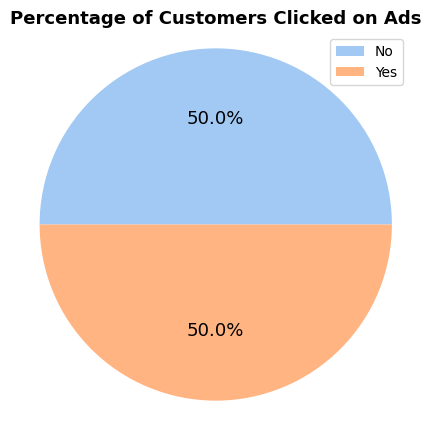

In [535]:
# comparisons Clicked on Ad
plt.figure(figsize=(5,5))
plt.pie(df['Clicked on Ad'].value_counts(), labels=None, autopct='%1.1f%%', colors=sns.color_palette('pastel'), textprops={'fontsize':13})
plt.legend(labels=df['Clicked on Ad'].unique(), loc='best')
plt.title('Percentage of Customers Clicked on Ads', weight='bold', fontsize=13)
plt.axis('equal')
plt.show()

# Pre-Processing

### Handling Missing Values

In [536]:
#cek missing values
print('Terdapat missing value sebanyak :')
print(df.isna().sum())
print('dari total data sebanyak :', df.shape[0])

Terdapat missing value sebanyak :
Daily Time Spent on Site    13
Age                          0
Area Income                 13
Daily Internet Usage        11
Gender                       3
Timestamp                    0
Clicked on Ad                0
city                         0
province                     0
category                     0
dtype: int64
dari total data sebanyak : 1000


In [537]:
#fill missing values
df['Daily Time Spent on Site'] =  df['Daily Time Spent on Site'].fillna(df['Daily Time Spent on Site'].mean())
df['Area Income'] =  df['Area Income'].fillna(df['Area Income'].mean())
df['Daily Internet Usage'] =  df['Daily Internet Usage'].fillna(df['Daily Internet Usage'].mean())
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])

### Handling Duplicates

In [538]:
if df.duplicated().sum()==0: print('tidak ada data duplicate')
else: print('terdapat data duplicated sebanyak :', df.duplicated().sum())

tidak ada data duplicate


### Handle Outlier

In [539]:
#z-score method
from scipy import stats

print(f'total data before handling outliers :', df.shape[0])

#select feature numerical
df_nums = df.select_dtypes(include=['float64', 'int64'])

#calculate z-score
zscore = np.abs(stats.zscore(df_nums))

#set threshold
threshold = 3

#identify outliers rows
outlier_rows = np.where(zscore > threshold)[0]

#remove outliers rows
df = df.drop(df.index[outlier_rows])

print(f'total data after removing outliers :', df.shape[0])


total data before handling outliers : 1000
total data after removing outliers : 997


### Extract Feature Timestamp

In [540]:
df['tahun'] = df['Timestamp'].apply(lambda x : x.year)
df['bulan'] = df['Timestamp'].apply(lambda x : x.month)
df['pekan'] = df['Timestamp'].apply(lambda x : x.week)
df['tanggal'] = df['Timestamp'].apply(lambda x : x.day)

### Feature Selection

In [541]:
df.drop(columns=['Timestamp', 'tahun'], inplace=True) # dataset focus on year 2016

### Feature Encoding

In [542]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dtype_object = ['Gender', 'Clicked on Ad', 'city', 'province', 'category']

for i in dtype_object:
    df[i] = le.fit_transform(df[i])

# Modelling

### Def Function

In [543]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Train Set): %.3f" % accuracy_score(y_train, y_pred_train))
    print("Accuracy (Test Set): %.3f" % accuracy_score(y_test, y_pred),"\n")

    print("Precision (Train Set): %.3f" % precision_score(y_train, y_pred_train))
    print("Precision (Test Set): %.3f" % precision_score(y_test, y_pred),"\n")

    print("Recall (Train Set): %.3f" % recall_score(y_train, y_pred_train))
    print("Recall (Test Set): %.3f" % recall_score(y_test, y_pred),"\n")

    print("F1-Score (Train Set): %.3f" % f1_score(y_train, y_pred_train))
    print("F1-Score (Test Set): %.3f" % f1_score(y_test, y_pred),"\n")
    
    print("roc_auc (train-proba): %.3f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    print("roc_auc (test-proba): %.3f" % roc_auc_score(y_test, y_pred_proba[:, 1]),"\n")
    
    score = cross_validate(model, X, y, cv=5, scoring='precision', return_train_score=True) # PRECISION >, FALSE POSITIVE <, Error Predictions for Customer Clicked on Ads <
    print('Precision (crossval train): '+ str(score['train_score'].mean()))
    print('Precision (crossval test): '+ str(score['test_score'].mean()),"\n")

def show_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                annot_kws={"size": 14}, linewidths=0.5, linecolor="grey")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix", fontsize=14)
    plt.show()

def show_feature_importance_tree(model): # only for tree based models; DecisionTree and RandomForest
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 5))
    ax.invert_yaxis()

    plt.xlabel('Score', fontsize=13)
    plt.ylabel('Feature', fontsize=13)
    plt.title('Feature Importance Score', fontsize=13)

def show_feature_importance_reg(model): # only for regression based models; LogisticRegression
    feat_importances = pd.Series(abs(model.coef_[0]), index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 5))
    ax.invert_yaxis()

    plt.xlabel('Coefficient Magnitude', fontsize=13)
    plt.ylabel('Feature', fontsize=13)
    plt.title('Feature Importance', fontsize=13) 
 
def show_best_hyperparameter(model): # only for tree based models; DecisionTree and RandomForest
    print(model.best_estimator_.get_params())

### Model Without Normalization

##### Split Data Test and Train

In [544]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Clicked on Ad'])
y = df[['Clicked on Ad']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Logistic Regression

In [545]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
eval_classification(lr)

Accuracy (Train Set): 0.508
Accuracy (Test Set): 0.475 

Precision (Train Set): 0.000
Precision (Test Set): 0.000 

Recall (Train Set): 0.000
Recall (Test Set): 0.000 

F1-Score (Train Set): 0.000
F1-Score (Test Set): 0.000 

roc_auc (train-proba): 0.772
roc_auc (test-proba): 0.750 

Precision (crossval train): 0.0
Precision (crossval test): 0.0 



##### Decision Tree

In [546]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
eval_classification(dt)

Accuracy (Train Set): 1.000
Accuracy (Test Set): 0.925 

Precision (Train Set): 1.000
Precision (Test Set): 0.933 

Recall (Train Set): 1.000
Recall (Test Set): 0.924 

F1-Score (Train Set): 1.000
F1-Score (Test Set): 0.928 

roc_auc (train-proba): 1.000
roc_auc (test-proba): 0.925 

Precision (crossval train): 1.0
Precision (crossval test): 0.9371864648701145 



##### Random Forest

In [547]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
eval_classification(rf)

Accuracy (Train Set): 1.000
Accuracy (Test Set): 0.955 

Precision (Train Set): 1.000
Precision (Test Set): 0.953 

Recall (Train Set): 1.000
Recall (Test Set): 0.962 

F1-Score (Train Set): 1.000
F1-Score (Test Set): 0.957 

roc_auc (train-proba): 1.000
roc_auc (test-proba): 0.986 

Precision (crossval train): 1.0
Precision (crossval test): 0.9634395592778298 



### Model With Normalization

##### Feature Transformation

In [548]:
# Standard Scaler (mean=0, std=1)
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
num_col = df_nums.columns

for i in num_col:
    df[i] = ss.fit_transform(df[i].values.reshape(-1,1))

# Split feature and target
X = df.drop(columns=['Clicked on Ad'])
y = df[['Clicked on Ad']]


##### Split Data Test and Train

In [549]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Logistic Regression

In [550]:
lr.fit(X_train, y_train)
eval_classification(lr)

Accuracy (Train Set): 0.969
Accuracy (Test Set): 0.975 

Precision (Train Set): 0.977
Precision (Test Set): 0.981 

Recall (Train Set): 0.959
Recall (Test Set): 0.971 

F1-Score (Train Set): 0.968
F1-Score (Test Set): 0.976 

roc_auc (train-proba): 0.991
roc_auc (test-proba): 0.991 

Precision (crossval train): 0.9764833039814912
Precision (crossval test): 0.9734968987595038 



##### Decision Tree

In [551]:
dt.fit(X_train, y_train)
eval_classification(dt)

Accuracy (Train Set): 1.000
Accuracy (Test Set): 0.925 

Precision (Train Set): 1.000
Precision (Test Set): 0.933 

Recall (Train Set): 1.000
Recall (Test Set): 0.924 

F1-Score (Train Set): 1.000
F1-Score (Test Set): 0.928 

roc_auc (train-proba): 1.000
roc_auc (test-proba): 0.925 

Precision (crossval train): 1.0
Precision (crossval test): 0.9371864648701145 



##### Random Forest

In [552]:
rf.fit(X_train, y_train)
eval_classification(rf)

Accuracy (Train Set): 1.000
Accuracy (Test Set): 0.955 

Precision (Train Set): 1.000
Precision (Test Set): 0.953 

Recall (Train Set): 1.000
Recall (Test Set): 0.962 

F1-Score (Train Set): 1.000
F1-Score (Test Set): 0.957 

roc_auc (train-proba): 1.000
roc_auc (test-proba): 0.986 

Precision (crossval train): 1.0
Precision (crossval test): 0.9615564297884103 



### Hyperparameter Tuning

In [553]:
# Based on experiment result in precision score, we choose Logistic Regression with the data being normalized

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define Hyperparameter Space
param_grid = {
    'C' : [0.01, 0.1, 1.0, 10.0], # parameter nilai untuk regularization (C)
    'solver' : ['lbfgs', 'liblinear', 'sag', 'saga'] #parameter algorithma solver yang digunakan
}

lrt = LogisticRegression()
grid_search = GridSearchCV(lrt, param_grid, cv=5, scoring='precision')
grid_search.fit(X_train, y_train)

# Best Parameter Selection
best_params = grid_search.best_params_
print('Best Hyperparameters :', best_params)

# Fit Best Parameter into Model
best_lr = grid_search.best_estimator_

# Evaluation Results
eval_classification(best_lr)

Best Hyperparameters : {'C': 0.01, 'solver': 'lbfgs'}
Accuracy (Train Set): 0.962
Accuracy (Test Set): 0.970 

Precision (Train Set): 0.995
Precision (Test Set): 1.000 

Recall (Train Set): 0.929
Recall (Test Set): 0.943 

F1-Score (Train Set): 0.960
F1-Score (Test Set): 0.971 

roc_auc (train-proba): 0.990
roc_auc (test-proba): 0.992 

Precision (crossval train): 0.9941103178174104
Precision (crossval test): 0.9935011225333806 



### Feature Importance

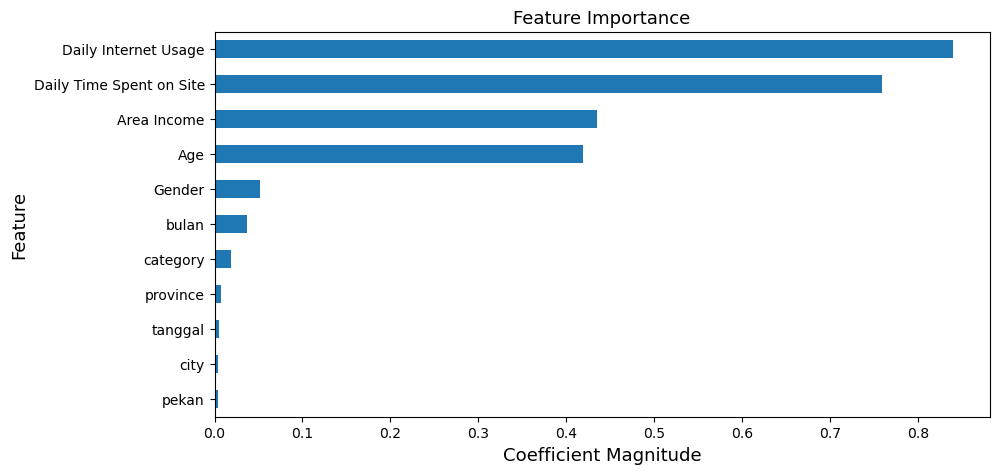

In [554]:
# Cek Feature Importance
show_feature_importance_reg(best_lr) 

In [555]:
error

NameError: name 'error' is not defined

# Evaluation

## Feature Importance

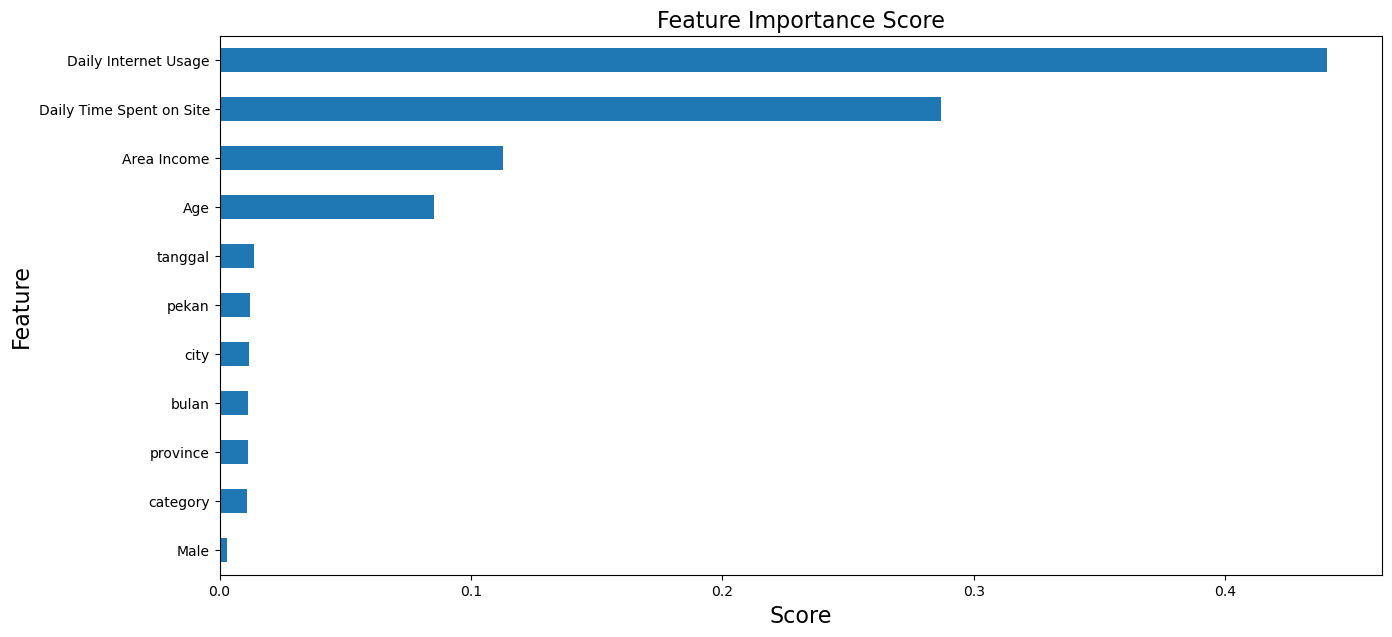

In [ ]:
# Cek Features Importance
show_feature_importance(rf) #menggunakan Random Forest dengan Data Train Normal karena memiliki nilai evaluasi score terbaik

## Analyze Performance

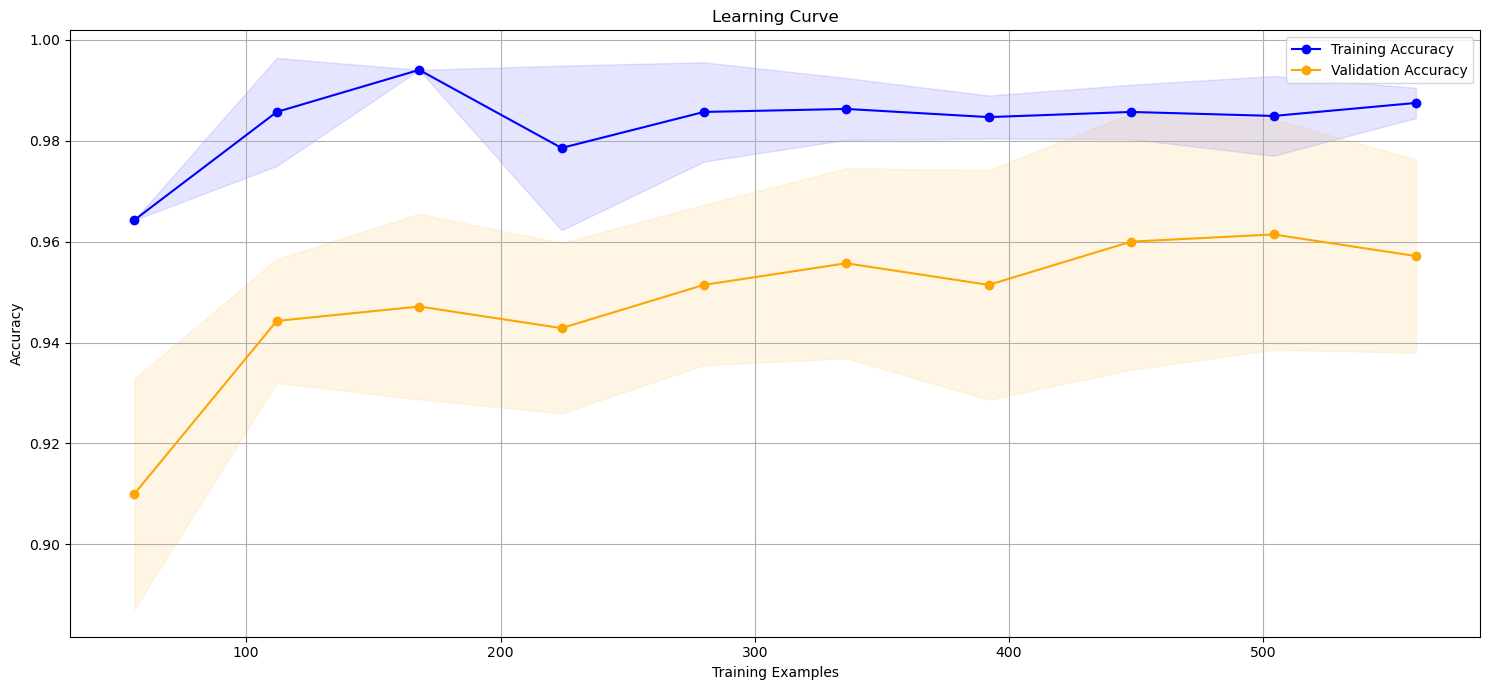

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1, 10))

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,7))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy', color='blue') #'o-' memberi dot pada plots
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue') #untuk melihat jarak std terhadap mean pada plot
    plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy', color='orange')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')

    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')

    plt.grid() #memberi grid pada grafik
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

plot_learning_curve(rs_rf, X_train, y_train)

## Confusion Matrix

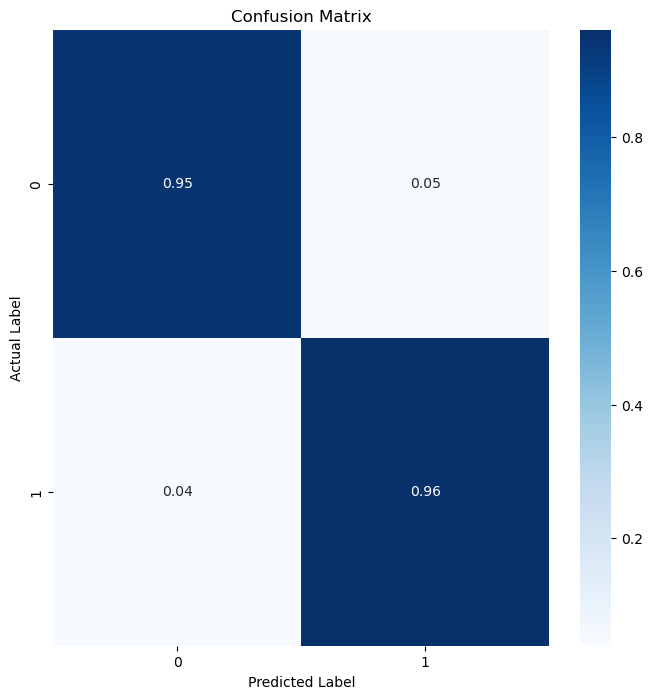

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes): #y_true = actual event, y_pred = prediction event
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #normalize (make value of matrix to : 0 - 1)

    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

y_pred = rs_rf.predict(X_test)
plot_confusion_matrix(y_test, y_pred, ['0', '1'])